This is an exercise in reinforcement learning.  An <b>agent</b> (our AI) makes moves in an <b>environment</b> (our gameboard) using a <b>policy</b> to determine the best move in a given <b>state</b>.

In [1]:
import numpy as np
import random as r
import matplotlib.pyplot as plt

# defining string constants for specifying policies to use
RANDOM_POLICY = "random_policy"
GREEDY_POLICY = "greedy_policy"
GREEDY_BUT_TYTHING_POLICY = "greedy_but_tything_policy"

In [2]:
# Creating the environment for our agent to interact with.  A gameboard for tic tac toe.
class GameBoard:
    def __init__(self, dim=3, grid = None):
        if np.any(grid == None):
            self.grid = np.zeros((dim, dim), dtype=np.int)
            self.dim = dim
        else:
            self.grid = grid
            self.dim = grid.shape[0]
        self.game_over = False
        self.game_has_winner = False
        self.outcome = 0 #default value to be replaced by 1 for "X" or -1 for "O"

    def reset(self):
        self.grid = np.zeros((self.dim, self.dim), dtype=np.int)
        self.game_over = False
        self.game_has_winner = False
        self.outcome = 0        
        
    def available_moves(self):
        result = np.where(self.grid == 0)
        listOfCoordinates = list(zip(result[0], result[1]))
        return listOfCoordinates

    #enter a move, 1 being "X", -1 being "O"
    def update_state(self, coords, val):
        self.grid[coords] = val
    
    def get_state(self):
        return self.grid
    
    def view_state(self):
        print(self.grid)
        
    def evaluate_position(self):
        # first check if there is a winner
        # if a row, column, or diagonal adds up to dim or -dim, it mean X or O has won, respectively
        row_comp = np.any(np.abs(np.sum(self.grid, axis = 1)) == self.dim)
        col_comp = np.any(np.abs(np.sum(self.grid, axis = 0)) == self.dim)
        diag_comp = np.abs(np.trace(self.grid)) == self.dim
        anti_diag_comp = np.abs(np.trace(np.flipud(self.grid))) == self.dim
        if row_comp or col_comp or diag_comp or anti_diag_comp:
            self.game_over = True
            self.game_has_winner = True
        # check if the grid is filled
        # a draw, since, neither player has won by the above criteria
        elif not np.any(self.grid == 0):
            self.game_over = True
            self.game_has_winner = False
    
    def determine_winner(self):
        self.evaluate_position()
        if self.game_has_winner:
            row_comp = np.any(np.sum(self.grid, axis = 1) == self.dim)
            col_comp = np.any(np.sum(self.grid, axis = 0) == self.dim)
            diag_comp = np.trace(self.grid) == self.dim
            anti_diag_comp = np.trace(np.flipud(self.grid)) == self.dim
            if row_comp or col_comp or diag_comp or anti_diag_comp:
                self.outcome = 1
            else:
                self.outcome = -1
    
    def result(self):
        self.determine_winner()
        if self.game_over and self.game_has_winner:
            if self.outcome == 1:
                print("X won!")
            else:
                print("O won!")
        elif self.game_over:
            print("It's a draw")
        else:
            print("Game in progress")

In [3]:
# defining our agent that will be playing the game
class Agent:
    def __init__(self, epsilon=0.1, discount_factor=0.8, learning_rate=0.1, tythe_rate = 0.5,
                 move=1): # move=1 for X, -1 for O
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.tythe_rate = tythe_rate
        self.move = move
        self.game_list = []
        
    def reset(self):
        self.game_list = []
    
    # deprecated
    def calculate_rewards(self, game):
        reward = self.move * game.outcome
        for i in range(1, len(self.game_list)+1):
            self.game_list[-i]['reward'] = self.discount_factor**(i-1) * reward
    
    # deprecated
    def update_value_table_mc(self, game, value_table):
        self.calculate_rewards(game)
        for item in self.game_list:
            key = item['new_state']
            reward = item['reward']
            if key not in value_table.keys():
                value_table[key] = 0
            value_table[key] += self.learning_rate * (reward - value_table[key])
    
#     # the more effective optimisation algorithm
#     # kudos to Haron Shams for explaining this to me, and for example code
#     def update_value_table_bellman(self, game, value_table):
#         reward = self.move * game.outcome
#         for i in range(1, len(self.game_list)+1):
#             key = self.game_list[-i]['new_state']
#             dim = game.dim
#             if key not in value_table:
#                 value_table[key] = 0
#             if i == 1:
#                 calculated_value = reward
#             else:
#                 calculated_value = self.discount_factor * (self.value_of_best_move(key, dim, value_table))
#             value_table[key] += self.learning_rate * (calculated_value - value_table[key])

            
            
    # we will adopt the convention that self.move = 1 to reduce the complexity of the following code
    def update_value_table_bellman(self, agent, game, value_table):
        dim = game.dim
        game_list_X = self.game_list.copy()
        game_list_O = agent.game_list.copy()
        game_list = [game_list_X, game_list_O]
        agents = [self, agent]
        final_move = True # only the final move will not be suppressed by the discount factor
        # determining who moved last
        if len(game_list_X) > len(game_list_O):
            index = 0
            inc = -1
        else:
            index = 1
            inc = 1
        
        while len(game_list_X) > 0 or len(game_list_O) > 0:
            key = game_list[index][-1]['new_state']
            current_agent = agents[index]
            opposing_agent = agents[index-1]
            if key not in value_table:
                value_table[key] = 0
            if final_move:
                calculated_value = current_agent.move * game.outcome
                final_move = False
            else:
                # a bit complicated, but we are valuing the move based on the best follow-up move by the 
                # opponent.  So the better the opponent's response, the heavier the penalty, hence the (-1) factor, since
                # it's the opponent's move in the new state
                calculated_value = (-1) * current_agent.discount_factor * (opposing_agent.value_of_best_move(key, dim, value_table))
            value_table[key] += current_agent.learning_rate * (calculated_value - value_table[key])
            del game_list[index][-1]
            inc = -inc
            index +=inc


    def value_of_best_move(self, encoded_state, dim, value_table):
        # return an array with the dimension dim and entries in the encoded state
        grid = self.decode_state(encoded_state, dim)
        game = GameBoard(dim=dim, grid=grid)
        return self.greedy_policy(game, value_table, return_max_score = True)
    
    def decode_state(self, encoded_state, dim):
        grid = np.zeros((dim, dim), dtype=np.int)
        upto = encoded_state.find('-1:')
        xs = encoded_state[3:upto]
        os = encoded_state[upto+3:]
        len1=len(xs)
        len2=len(os)
        for i in range(int(len1/2)):
            grid[int(xs[2*i]), int(xs[2*i+1])] = 1
        for i in range(int(len2/2)):
            grid[int(os[2*i]), int(os[2*i+1])] = -1
        return grid
        
    # value table is a dictionary of states and values.  game.get_state is a numpy array that can't be used
    # as a dictionary key.  We encode the state as a string for it to be usable.  If the agent plays O's,
    # we will multiply the matrix by move (-1) first, so that the state is the same for both X and O
    def encode_state(self, game):
        state = game.get_state()
        xs = np.where(state == 1)
        os = np.where(state == -1)
        xcoords = list(zip(xs[0], xs[1]))
        ocoords = list(zip(os[0], os[1]))
        encoded_state = '+1:'
        for tup in xcoords:
            for a in tup:
                encoded_state +=str(a)
        encoded_state +='-1:'
        for tup in ocoords:
            for a in tup:
                encoded_state +=str(a)
        return encoded_state

    def take_action(self, game, value_table, policy_string):
        if policy_string == RANDOM_POLICY:
            policy = self.random_policy
        elif policy_string == GREEDY_POLICY:
            policy = self.greedy_policy
        elif policy_string == GREEDY_BUT_TYTHING_POLICY:
            policy = self.greedy_but_tything_policy
        action = policy(game, value_table)
        game.update_state(action, self.move)
    
    def random_policy(self, game, value_table):
        return r.choice(game.available_moves())

    def greedy_policy(self, game, value_table, return_max_score=False):
        available_moves = game.available_moves() # i.e. get unfilled positions in grid
        move_scores = []
        for available_move in available_moves:
            game.update_state(available_move, self.move) # getting position after potential move is made
            encoded_state = self.encode_state(game)
            if encoded_state not in value_table.keys():
#                 value_table[encoded_state] = 0
                game.update_state(available_move, 0)
                continue
            move_scores.append(value_table[encoded_state]) # getting value of new position
            game.update_state(available_move, 0) # resetting to the original game position
        if len(move_scores) == 0:
            max_score = 0
            max_index = r.randint(0,len(available_moves)-1)
        else:
            max_score = max(move_scores)
            max_inds = [i for i,j in enumerate(move_scores) if j==max_score]
            max_index = r.choice(max_inds)
        if return_max_score:
            return max_score
        return available_moves[max_index]
    
    def greedy_but_tything_policy(self, game, value_table): 
    # i.e. 1/10th of the time it makes a random move, the rest of the time it is greedy
        if r.random() < self.tythe_rate:
            return self.random_policy(game, value_table)
        else:
            return self.greedy_policy(game, value_table)
    
    def visualize_value_table(self, game, value_table):
        value_grid = np.zeros((game.dim, game.dim))
        available_moves = game.available_moves() # i.e. get unfilled positions in grid
        for available_move in available_moves:
            game.update_state(available_move, self.move) # getting position after potential move is made
            encoded_state = self.encode_state(game)
            if encoded_state not in value_table.keys():
                value_grid[available_move] = np.Infinity
            else:
                value_grid[available_move] += value_table[encoded_state] # inserting value of move
#             print(value_table[encoded_state])
            game.update_state(available_move, 0) # resetting to the original game position
        value_grid += game.grid
        print(value_grid)

In [4]:
def play_single_game(agents, policies, value_table, game):
    index = 0
    inc = 1
    while not game.game_over:
        move_summary = {}
        agent = agents[index]
        policy = policies[index]
        move_summary['old_state'] = agent.encode_state(game)
        agent.take_action(game, value_table, policy)
        move_summary['new_state'] = agent.encode_state(game)
        agent.game_list.append(move_summary)
        game.evaluate_position()
        inc *=-1
        index +=inc

In [ ]:
value_table = {}
agents = [Agent(move=1), Agent(move=-1)]
game = GameBoard(4)
training_policies = [GREEDY_BUT_TYTHING_POLICY, GREEDY_BUT_TYTHING_POLICY]
test_policies1 = [GREEDY_POLICY, RANDOM_POLICY]
test_policies2 = [RANDOM_POLICY, GREEDY_POLICY]
test_policies3 = [GREEDY_POLICY, GREEDY_POLICY]
num_epochs = 100000

epoch_num = []
x_vs_random = {'x wins':[], 'x loses':[], 'x draws':[]}
o_vs_random = {'o wins':[], 'o loses':[], 'o draws':[]}
x_vs_o = {'x wins':[], 'o wins':[], 'draws':[]}

for i in range(num_epochs):
    play_single_game(agents, training_policies, value_table, game)
    game.determine_winner()
    agents[0].update_value_table_bellman(agents[1], game, value_table)
    agents[0].reset()
    agents[1].reset()
    game.reset()
    if (i+1)%1000==0:
        print(f"Epoch: {i+1}")
        epoch_num.append(i+1)
        x_wins, x_losses, x_draws = 0, 0, 0
        o_wins, o_losses, o_draws = 0, 0, 0
        x_wins2, o_wins2, draws2 = 0, 0, 0
        for j in range(100):
            play_single_game(agents,test_policies1, value_table, game)
            game.determine_winner()
            if game.outcome == 1:
                x_wins +=1
            elif game.outcome == -1:
                x_losses +=1
            elif game.outcome == 0:
                x_draws +=1
            game.reset()
            agents[0].reset()
            agents[1].reset()
        x_vs_random['x wins'].append(x_wins)
        x_vs_random['x loses'].append(x_losses)
        x_vs_random['x draws'].append(x_draws)
        for j in range(100):
            play_single_game(agents,test_policies2, value_table, game)
            game.determine_winner()
            if game.outcome == -1:
                o_wins +=1
            elif game.outcome == 1:
                o_losses +=1
            elif game.outcome == 0:
                o_draws +=1
            game.reset()
            agents[0].reset()
            agents[1].reset()
        o_vs_random['o wins'].append(o_wins)
        o_vs_random['o loses'].append(o_losses)
        o_vs_random['o draws'].append(o_draws)
        for j in range(100):
            play_single_game(agents,test_policies3, value_table, game)
            game.determine_winner()
            if game.outcome == 1:
                x_wins2 +=1
            elif game.outcome == -1:
                o_wins2 +=1
            elif game.outcome == 0:
                draws2 +=1
            game.reset()
            agents[0].reset()
            agents[1].reset()
        x_vs_o['x wins'].append(x_wins2)
        x_vs_o['o wins'].append(o_wins2)
        x_vs_o['draws'].append(draws2)

Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
Epoch: 6000
Epoch: 7000
Epoch: 8000
Epoch: 9000
Epoch: 10000
Epoch: 11000
Epoch: 12000
Epoch: 13000
Epoch: 14000
Epoch: 15000
Epoch: 16000
Epoch: 17000
Epoch: 18000
Epoch: 19000
Epoch: 20000
Epoch: 21000
Epoch: 22000
Epoch: 23000
Epoch: 24000
Epoch: 25000
Epoch: 26000
Epoch: 27000
Epoch: 28000
Epoch: 29000
Epoch: 30000
Epoch: 31000
Epoch: 32000
Epoch: 33000
Epoch: 34000
Epoch: 35000
Epoch: 36000
Epoch: 37000
Epoch: 38000
Epoch: 39000
Epoch: 40000
Epoch: 41000
Epoch: 42000
Epoch: 43000
Epoch: 44000
Epoch: 45000
Epoch: 46000
Epoch: 47000
Epoch: 48000
Epoch: 49000
Epoch: 50000
Epoch: 51000
Epoch: 52000
Epoch: 53000
Epoch: 54000
Epoch: 55000
Epoch: 56000
Epoch: 57000
Epoch: 58000
Epoch: 59000


In [10]:
x_vs_random

{'x wins': [24,
  42,
  40,
  28,
  31,
  33,
  41,
  34,
  47,
  53,
  32,
  30,
  41,
  46,
  46,
  45,
  54,
  38,
  34,
  43,
  28,
  34,
  37,
  44,
  51,
  46,
  50,
  44,
  46,
  46,
  44,
  42,
  30,
  30,
  47,
  46,
  29,
  29,
  44,
  34,
  41,
  55,
  39,
  40,
  45,
  37,
  45,
  34,
  40,
  49,
  38,
  33,
  35,
  56,
  59,
  54,
  40,
  40,
  48,
  47,
  54,
  44,
  54,
  50,
  34,
  54,
  43,
  32,
  37,
  45,
  50,
  41,
  52,
  55,
  36,
  44,
  50,
  58,
  44,
  50,
  58,
  40,
  30,
  37,
  40,
  45,
  37,
  44,
  38,
  38,
  35,
  35,
  42,
  42,
  37,
  44,
  45,
  50,
  42,
  49],
 'x loses': [31,
  17,
  20,
  37,
  19,
  25,
  28,
  22,
  25,
  20,
  30,
  29,
  19,
  24,
  29,
  24,
  23,
  22,
  25,
  22,
  27,
  26,
  25,
  31,
  21,
  19,
  23,
  18,
  25,
  25,
  23,
  29,
  31,
  30,
  17,
  17,
  30,
  17,
  19,
  25,
  18,
  17,
  26,
  20,
  18,
  26,
  19,
  32,
  28,
  22,
  19,
  31,
  24,
  23,
  18,
  22,
  20,
  22,
  25,
  20,
  21,
  22,
  23,


4x4 board

In [ ]:
plt.figure()
ax1 = plt.subplot(111)
ax1.plot(epoch_num, x_vs_random['x wins'], c='g', label='x wins')
ax1.plot(epoch_num, x_vs_random['x loses'], c='r', label='x loses')
ax1.plot(epoch_num, x_vs_random['x draws'], c='b', label='x draws')
plt.xlabel('Epoch Number')
plt.ylabel('Result Count')
plt.title('X using learned policy vs Random player out of 100 games')
ax1.legend()
plt.show()

plt.figure()
ax2 = plt.subplot(111)
ax2.plot(epoch_num, o_vs_random['o wins'], c='g', label='o wins')
ax2.plot(epoch_num, o_vs_random['o loses'], c='r', label='o loses')
ax2.plot(epoch_num, o_vs_random['o draws'], c='b', label='o draws')
plt.xlabel('Epoch Number')
plt.ylabel('Result Count')
plt.title('O using learned policy vs Random player out of 100 games')
ax2.legend()
plt.show()

plt.figure()
ax3 = plt.subplot(111)
ax3.plot(epoch_num, x_vs_o['x wins'], c='g', label='x wins')
ax3.plot(epoch_num, x_vs_o['o wins'], c='r', label='o wins')
ax3.plot(epoch_num, x_vs_o['draws'], c='b', label='draws')
plt.xlabel('Epoch Number')
plt.ylabel('Result Count')
plt.title('X vs O using same learned policy out of 100 games')
ax3.legend()
plt.show()

3x3 board

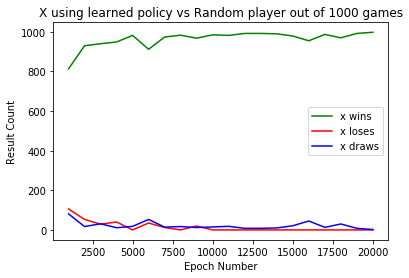

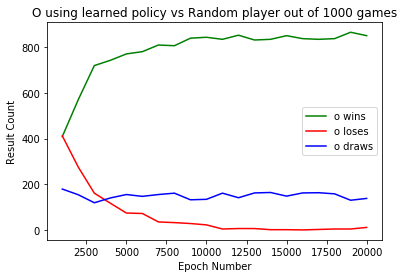

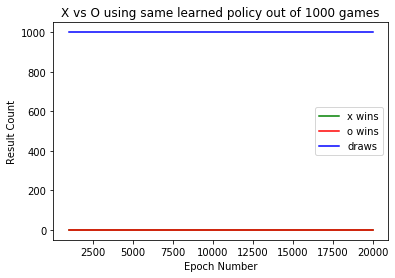

In [27]:
plt.figure()
ax1 = plt.subplot(111)
ax1.plot(epoch_num, x_vs_random['x wins'], c='g', label='x wins')
ax1.plot(epoch_num, x_vs_random['x loses'], c='r', label='x loses')
ax1.plot(epoch_num, x_vs_random['x draws'], c='b', label='x draws')
plt.xlabel('Epoch Number')
plt.ylabel('Result Count')
plt.title('X using learned policy vs Random player out of 1000 games')
ax1.legend()
plt.show()

plt.figure()
ax2 = plt.subplot(111)
ax2.plot(epoch_num, o_vs_random['o wins'], c='g', label='o wins')
ax2.plot(epoch_num, o_vs_random['o loses'], c='r', label='o loses')
ax2.plot(epoch_num, o_vs_random['o draws'], c='b', label='o draws')
plt.xlabel('Epoch Number')
plt.ylabel('Result Count')
plt.title('O using learned policy vs Random player out of 1000 games')
ax2.legend()
plt.show()

plt.figure()
ax3 = plt.subplot(111)
ax3.plot(epoch_num, x_vs_o['x wins'], c='g', label='x wins')
ax3.plot(epoch_num, x_vs_o['o wins'], c='r', label='o wins')
ax3.plot(epoch_num, x_vs_o['draws'], c='b', label='draws')
plt.xlabel('Epoch Number')
plt.ylabel('Result Count')
plt.title('X vs O using same learned policy out of 1000 games')
ax3.legend()
plt.show()

In [10]:
len(value_table)
# 3**25

807110

In [20]:
asdf = '+1:0002-1:11'
value_table[asdf]

0.0

In [6]:
## ok, let's see how well the ai does trained on a random policy, then a semi-greedy policy using the same value table
# computer goes first
game = GameBoard(3)
agent = Agent()
policy = GREEDY_POLICY

while not game.game_over:
    agent.take_action(game, value_table, policy)
    game.evaluate_position()
    if game.game_over:
        break
    game.view_state()
    if agent.encode_state(game) in value_table:
        print(value_table[agent.encode_state(game)])
    row = int(input("Row of move:"))
    col = int(input("Column of move:"))
    game.update_state((row, col), -1)
    if agent.encode_state(game) in value_table:
        agent.visualize_value_table(game, value_table)
        print(value_table[agent.encode_state(game)])
    game.evaluate_position()

game.view_state()
game.result()

[[0 0 0]
 [0 1 0]
 [0 0 0]]
5.821653024662272e-07
Row of move:2
Column of move:2
[[ 0.00000000e+00  2.29944293e-03  2.51178405e-02]
 [-6.08627094e-03  1.00000000e+00  6.47554960e-04]
 [-9.50461858e-04  5.63535071e-04 -1.00000000e+00]]
-0.016463393706004907
[[ 0  0  1]
 [ 0  1  0]
 [ 0  0 -1]]
0.025117840474469296
Row of move:2
Column of move:0
[[-0.1197744  -0.15937976  1.        ]
 [-0.2986534   1.         -0.38347182]
 [-1.          0.05729136 -1.        ]]
-0.0375268064433945
[[ 0  0  1]
 [ 0  1  0]
 [-1  1 -1]]
0.05729135513781111
Row of move:0
Column of move:1
[[ 0.         -1.          1.        ]
 [ 0.10066403  1.          0.        ]
 [-1.          1.         -1.        ]]
-0.08688025540204633
[[ 0 -1  1]
 [ 1  1  0]
 [-1  1 -1]]
0.10066403044273424
Row of move:1
Column of move:2
[[ 0. -1.  1.]
 [ 1.  1. -1.]
 [-1.  1. -1.]]
0.0
[[ 1 -1  1]
 [ 1  1 -1]
 [-1  1 -1]]
It's a draw


In [8]:
# ok, let's see how well the ai does trained on a random policy, then a semi-greedy policy using the same value table
# human goes first
game = GameBoard(3)
agent = Agent(move=-1)
policy = GREEDY_POLICY

while not game.game_over:
    game.view_state()
    row = int(input("Row of move:"))
    col = int(input("Column of move:"))
    game.update_state((row, col), 1)
    game.evaluate_position()
    if game.game_over:
        break
    agent.take_action(game, value_table, policy)
    game.evaluate_position()

game.view_state()
game.result()

[[0 0 0]
 [0 0 0]
 [0 0 0]]
Row of move:0
Column of move:0
[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0  0]]
Row of move:1
Column of move:2
[[ 1 -1  0]
 [ 0 -1  1]
 [ 0  0  0]]
Row of move:2
Column of move:1
[[ 1 -1  0]
 [ 0 -1  1]
 [-1  1  0]]
Row of move:0
Column of move:2
[[ 1 -1  1]
 [ 0 -1  1]
 [-1  1 -1]]
Row of move:1
Column of move:0
[[ 1 -1  1]
 [ 1 -1  1]
 [-1  1 -1]]
It's a draw


In [76]:
game.dim

3

In [74]:
asdf = game.get_state()

In [75]:
asdf

array([[-1, -1,  1],
       [ 1,  1,  1],
       [-1,  1, -1]])

In [82]:
np.sum(asdf, axis = 0)

array([-1,  1,  1])

In [7]:
new_game = GameBoard()
move = 1 # 1 being the input for X
while not new_game.game_over:
    new_game.view_state()
    row = int(input("Row of move:"))
    col = int(input("Column of move:"))
    new_game.update_state((row, col), move)
    new_game.evaluate_position()
    move *=-1

new_game.view_state()
new_game.result()

[[0 0 0]
 [0 0 0]
 [0 0 0]]
Row of move:1
Column of move:1
[[0 0 0]
 [0 1 0]
 [0 0 0]]
Row of move:0
Column of move:0
[[-1  0  0]
 [ 0  1  0]
 [ 0  0  0]]
Row of move:1
Column of move:2
[[-1  0  0]
 [ 0  1  1]
 [ 0  0  0]]
Row of move:1
Column of move:0
[[-1  0  0]
 [-1  1  1]
 [ 0  0  0]]
Row of move:2
Column of move:0
[[-1  0  0]
 [-1  1  1]
 [ 1  0  0]]
Row of move:0
Column of move:2
[[-1  0 -1]
 [-1  1  1]
 [ 1  0  0]]
Row of move:0
Column of move:1
[[-1  1 -1]
 [-1  1  1]
 [ 1  0  0]]
Row of move:2
Column of move:1
[[-1  1 -1]
 [-1  1  1]
 [ 1 -1  0]]
Row of move:2
Column of move:2
[[-1  1 -1]
 [-1  1  1]
 [ 1 -1  1]]
It's a draw


In [8]:
new_game.winner

0

In [9]:
value_table = {}
agents = [Agent(move=1), Agent(move=-1)]
policy = GREEDY_BUT_TYTHING_POLICY

game = GameBoard(3)
index = 0
inc = 1

while not game.game_over:
    move_summary = {}
    agent = agents[index]
    move_summary['old_state'] = agent.encode_state(game)
    agent.take_action(game, value_table, policy)
    move_summary['new_state'] = agent.encode_state(game)
    agent.game_list.append(move_summary)
    game.evaluate_position()
    inc *=-1
    index +=inc
    game.view_state()

game.determine_winner()
agents[0].update_value_table_bellman(agents[1], game, value_table)

game.result()
# print(agents[0].game_list)
# print(agents[1].game_list)
print(value_table)
asdf=1
for pos in agents[0].game_list:
    print(f'{pos["new_state"]}: {value_table[pos["new_state"]]}')

[[1 0 0]
 [0 0 0]
 [0 0 0]]
[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0  0]]
[[ 1  0  0]
 [ 1 -1  0]
 [ 0  0  0]]
[[ 1 -1  0]
 [ 1 -1  0]
 [ 0  0  0]]
[[ 1 -1  0]
 [ 1 -1  1]
 [ 0  0  0]]
[[ 1 -1 -1]
 [ 1 -1  1]
 [ 0  0  0]]
[[ 1 -1 -1]
 [ 1 -1  1]
 [ 1  0  0]]
X won!
{'+1:00101220-1:010211': 0.5, '+1:001012-1:010211': -0.2, '+1:001012-1:0111': 0.08000000000000002, '+1:0010-1:0111': -0.03200000000000001, '+1:0010-1:11': 0.012800000000000004, '+1:00-1:11': -0.005120000000000002, '+1:00-1:': 0.0020480000000000008}
+1:00-1:: 0.0020480000000000008
+1:0010-1:11: 0.012800000000000004
+1:001012-1:0111: 0.08000000000000002
+1:00101220-1:010211: 0.5
